## Step 1 : install libraries

In [1]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt


# Step 2 : Set Constants

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Step : 3 Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/MyDrive/dataset"


In [5]:
train_dataset_raw = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 327 files belonging to 2 classes.
Using 262 files for training.


In [6]:
validation_dataset_raw = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [7]:
import os
os.listdir("/content/drive/MyDrive/dataset")


['not alpaca', 'alpaca']

# Step: 4 Data Prefetching

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset_raw.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset_raw.prefetch(buffer_size=AUTOTUNE)

# Step 5: Data Augmentation

In [9]:
def data_augmenter():
    return Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(0.1)
    ])

data_augmentation = data_augmenter()


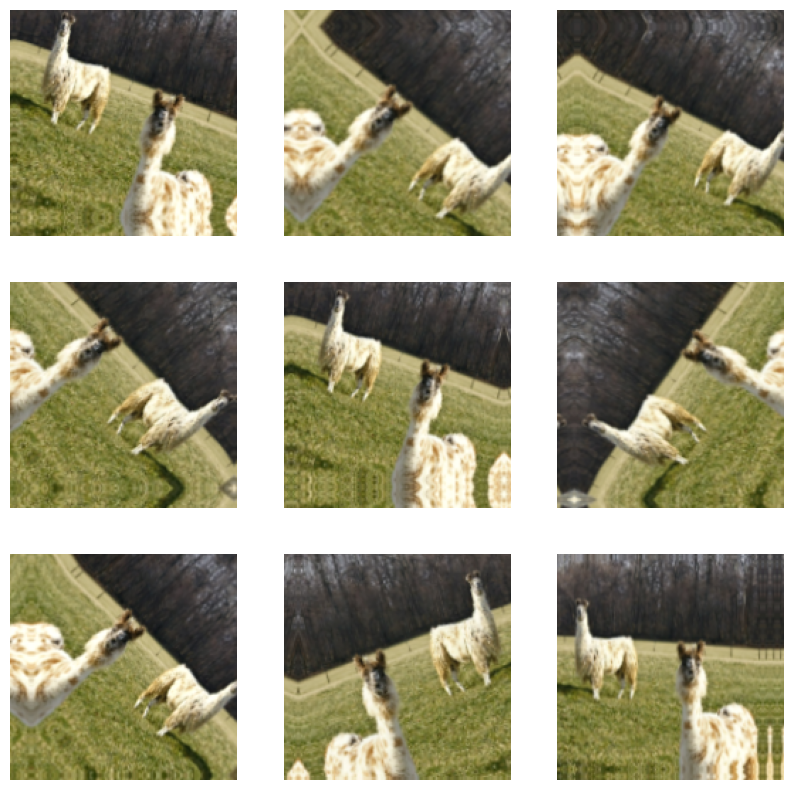

In [10]:
for images, _ in train_dataset.take(1):
    sample_image = images[0]

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Apply augmentation
        augmented_img = data_augmentation(tf.expand_dims(sample_image, 0))
        plt.imshow(augmented_img[0].numpy().astype("uint8"))
        plt.axis("off")
    break

# Step 6: Buid Model Using MobileNetV2

In [11]:
def build_alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs, outputs)
    return model

model = build_alpaca_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Step 7: Compile model

In [12]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Step 8: Train Model

In [13]:
initial_epochs = 5
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=initial_epochs)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step - accuracy: 0.4894 - loss: 0.8410 - val_accuracy: 0.6000 - val_loss: 0.6881
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 259ms/step - accuracy: 0.5621 - loss: 0.6972 - val_accuracy: 0.7385 - val_loss: 0.5440
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.6102 - loss: 0.6735 - val_accuracy: 0.7692 - val_loss: 0.4458
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.7236 - loss: 0.5477 - val_accuracy: 0.8308 - val_loss: 0.3851
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.7679 - loss: 0.4518 - val_accuracy: 0.8769 - val_loss: 0.3362


Step 9: Fine Tune

Even though we unfreezed the whole base model, the below line says:

“Still keep the first 120 layers frozen, and only train the remaining layers."

In [14]:
# Unfreeze the base model
base_model = model.get_layer('mobilenetv2_1.00_160')
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate * 0.1),
              metrics=['accuracy'])

In [16]:
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step - accuracy: 0.7363 - loss: 0.6110 - val_accuracy: 0.8769 - val_loss: 0.2224
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - accuracy: 0.8568 - loss: 0.3733 - val_accuracy: 0.8923 - val_loss: 0.1711
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.8630 - loss: 0.2786 - val_accuracy: 0.9538 - val_loss: 0.1321
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - accuracy: 0.9339 - loss: 0.1923 - val_accuracy: 0.9538 - val_loss: 0.0987
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9454 - loss: 0.1654 - val_accuracy: 1.0000 - val_loss: 0.0811
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.9546 - loss: 0.1506 - val_accuracy: 1.0000 - val_loss: 0.0694


# Step 10: Plot the results

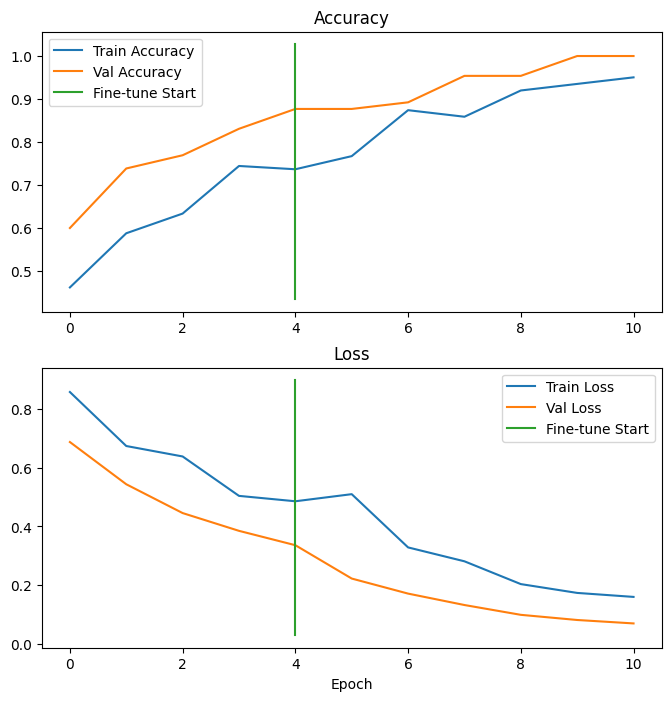

In [17]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Fine-tune Start')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Fine-tune Start')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


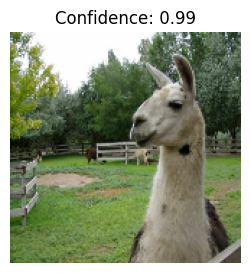

Predicted     : not alpaca
Actual Value  : alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


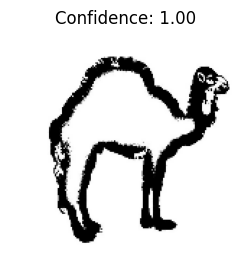

Predicted     : not alpaca
Actual Value  : not alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


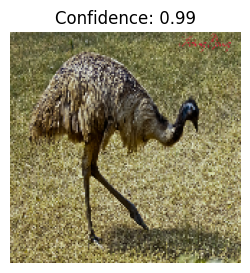

Predicted     : not alpaca
Actual Value  : not alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


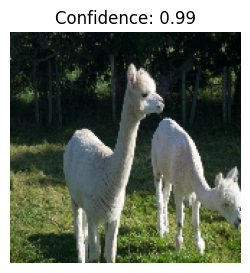

Predicted     : not alpaca
Actual Value  : alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


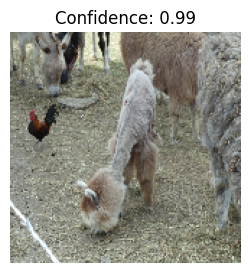

Predicted     : not alpaca
Actual Value  : alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


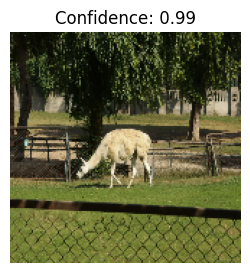

Predicted     : not alpaca
Actual Value  : alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


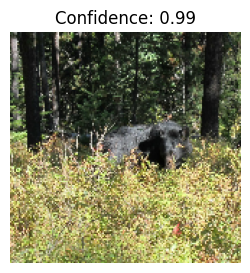

Predicted     : not alpaca
Actual Value  : not alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


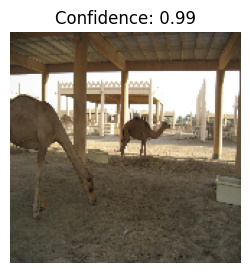

Predicted     : not alpaca
Actual Value  : not alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


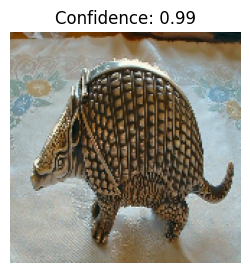

Predicted     : not alpaca
Actual Value  : not alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


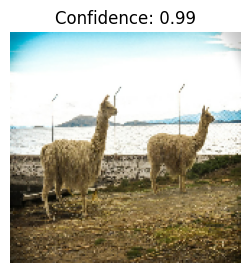

Predicted     : not alpaca
Actual Value  : alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


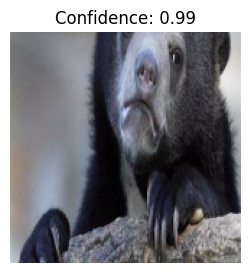

Predicted     : not alpaca
Actual Value  : not alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


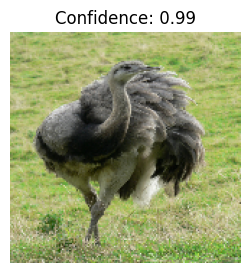

Predicted     : not alpaca
Actual Value  : not alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


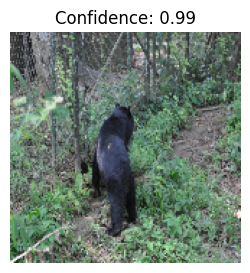

Predicted     : not alpaca
Actual Value  : not alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


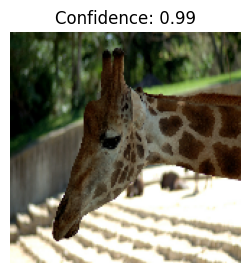

Predicted     : not alpaca
Actual Value  : not alpaca
-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


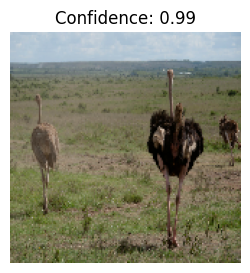

Predicted     : not alpaca
Actual Value  : not alpaca
-------------


In [18]:

# Access class_names from the original dataset before prefetching
class_names = train_dataset_raw.class_names

# Predict on a few validation images
for images, labels in validation_dataset.take(1):  # Take one batch
    for i in range(15):  # Predict on first 5 images in the batch
        img = images[i]
        true_label = labels[i].numpy()

        # Preprocess and predict
        img_array = tf.expand_dims(img, axis=0)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
        pred_logits = model.predict(img_array)
        prob = tf.nn.sigmoid(pred_logits[0][0]).numpy()
        pred_label = 1 if prob > 0.5 else 0

        # Display the image
        plt.figure(figsize=(3, 3))
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"Confidence: {prob:.2f}")
        plt.show()

        # Print clear results
        print("Predicted     :", class_names[pred_label])
        print("Actual Value  :", class_names[true_label])
        print("-------------")

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in validation_dataset:
    preds = model.predict(images)
    preds = tf.nn.sigmoid(preds).numpy()  # convert logits to probabilities
    preds = (preds > 0.5).astype(int).flatten()

    y_true.extend(labels.numpy())
    y_pred.extend(preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


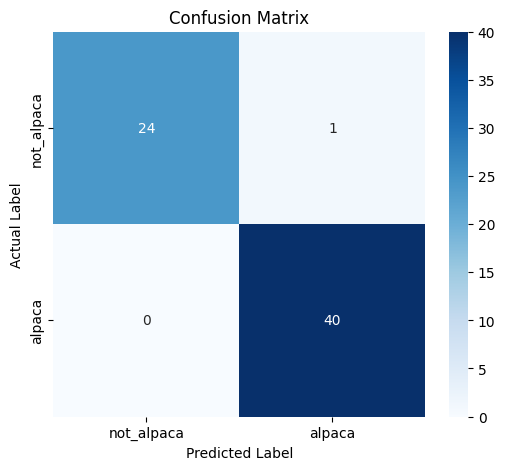

In [21]:
cm = confusion_matrix(y_true, y_pred)
class_names = ['not_alpaca', 'alpaca']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()


# Evaluate model on validation dataset

In [22]:

val_loss, val_accuracy = model.evaluate(validation_dataset)

print(f"\n✅ Final Validation Loss: {val_loss:.4f}")
print(f"✅ Final Validation Accuracy: {val_accuracy * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 0.0696

✅ Final Validation Loss: 0.0694
✅ Final Validation Accuracy: 100.00%


In [23]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"\n🟢 Final Training Accuracy: {train_accuracy * 100:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.9610 - loss: 0.1285

🟢 Final Training Accuracy: 97.71%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


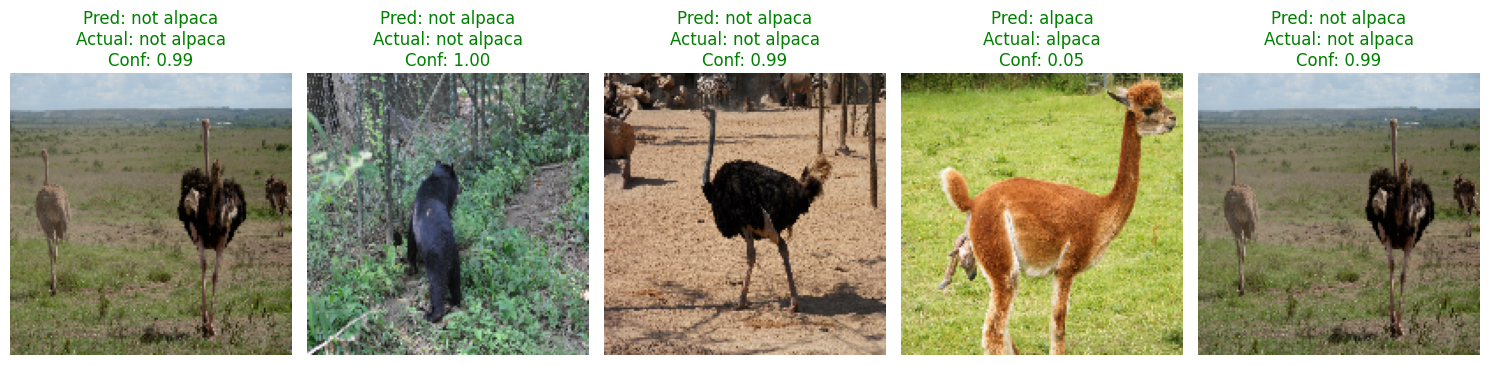

In [25]:
import random
import matplotlib.pyplot as plt
import numpy as np

class_names = validation_dataset_raw.class_names

# Getting one random batch from validation dataset
for images, labels in validation_dataset.shuffle(1000).take(1):
    plt.figure(figsize=(15, 10))

    for i in range(5):  # Show 5 random predictions
        index = random.randint(0, len(images) - 1)
        image = images[index]
        label = labels[index].numpy()

        # Make prediction
        pred_logits = model.predict(tf.expand_dims(image, 0))
        pred_prob = tf.nn.sigmoid(pred_logits[0]).numpy()
        pred_class = 1 if pred_prob > 0.5 else 0

        # Plot image
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.axis("off")

        # Show predicted and actual
        plt.title(
            f"Pred: {class_names[pred_class]}\n"
            f"Actual: {class_names[label]}\n"
            f"Conf: {pred_prob[0]:.2f}",
            color=("green" if pred_class == label else "red")
        )

    plt.tight_layout()
    plt.show()
    break